### makemore: lect03


### day14

- 202403120630--202403120800
- 202403122000--202403122100

### day 15
- 202403130845--202403131200
  
### day 16
- 202403140630--202403140800

### day 17
- 202403152100--202403152130


### day 18
- 202403161300--202403161500

  
### day 19
- 202403170900--20240317?
- 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List, Any

### Constants

In [2]:
RANDOM_SEED = 10
NUM_BLOCKS = 3
NUM_DIM_CHARS = 2
NUM_HIDDEN = 20

### Random Generator

In [3]:
import random
import numpy as np

rand_gen = torch.Generator().manual_seed(RANDOM_SEED)
RAND_GEN = rand_gen

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Read File

In [4]:
words = open("names.txt").read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

### Make Mappings: `chr -> int` and `int -> chr`

In [5]:
ord("a"), ord("z"), ord("z") - ord("a") + 1, chr(ord("a")), chr(ord("z"))

(97, 122, 26, 'a', 'z')

In [6]:
itos = {i - ord("a") + 1: chr(i) for i in range(ord("a"), ord("z") + 1)}
itos[0] = "."

stoi = {s: i for i, s in itos.items()}

# stoi
# itos

In [7]:
chars = sorted(list(set("".join(words))))
chars[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [8]:
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

### Get Data

In [9]:
def get_data(words: List[str], num_blocks: int = 3, stoi=stoi) -> (List[torch.tensor], List[torch.tensor]):
    """get data"""

    X, Y = [], []


    ### tese lines are for testing:
    # for word in words[:5]:
        # print("-" * 80)

    for word in words:
        context = [0] * num_blocks
        for ch in word + ".":
            i = stoi[ch]
            # append the current char ch, i.e. the index i into Y;
            # at the same time append the current context into X;
            # (the context up to now) contains letters that preeced the char ch
            # print(" ".join((itos[ix] for ix in context)), "--->", ch)
            X.append(context)
            Y.append(i)
            context = context[1: ] + [i]
           

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [10]:
get_data(words)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [11]:
num_blocks = NUM_BLOCKS
X, Y = get_data(words, num_blocks=num_blocks)

In [12]:
X[:10]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])

In [13]:
Y[:10]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])

### Split Data: `train`, `val/dev`, and `test`

In [14]:
X.shape, X.shape[0]

(torch.Size([228146, 3]), 228146)

In [15]:
Y.shape, Y.shape[0]

(torch.Size([228146]), 228146)

In [16]:
indexes = torch.randperm(X.shape[0], generator=rand_gen)
indexes[:10]

tensor([117017,  81926, 152774,   8097, 220660,  38770, 226753, 147220, 224337,
        175417])

In [17]:
# this list changes over time?!
torch.randperm(X.shape[0], generator=rand_gen)[:10]

tensor([184694,  31158,  21725,  15842,   3894,  75184,  50599, 156241, 116075,
         47106])

In [18]:
def split_data(X, y, split=0.8):
    
    """split data into train, val, and test sets"""
    
    assert X.shape[0] == y.shape[0], "input data X and Y sizes do not match."
    assert (0 < split and split < 1), "the split for training data should be within (0, 1)."
    
    len_data = X.shape[0]
    shuffled_indices = torch.randperm(X.shape[0], generator=rand_gen)

    len_train = int(split * len_data)
    len_val = (len_data - len_train) // 2
    len_test = len_data - len_train - len_val
    
    
    X_train = X[shuffled_indices][:len_train]
    X_val = X[shuffled_indices][len_train: len_train + len_val]
    X_test = X[shuffled_indices][- len_test:]
    
    y_train = Y[shuffled_indices][:len_train]
    y_val = Y[shuffled_indices][len_train: len_train + len_val]
    y_test = Y[shuffled_indices][- len_test:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [19]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)

In [20]:
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([22815, 3]),
 torch.Size([22815, 3]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

### MLP revisted

### Develop Model

- `C` is a mapping that translates `chars` into a `dim`-dimensional vector space;

In [21]:
### given the context X; 
### we predict the following char given in Y; 
### and the prediction belongs in one out of 27 classes; 
### i.e. there are 27 chars as a possibility for it. 

vocab_size = 27 

In [431]:
# MLP revisted
n_embed = 10 # the dimensionality of the char. embedding 
n_hidden = 200 # the number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * num_blocks, n_hidden), generator=g) * (5 /3) / ((n_embed * num_blocks) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.2
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

12297


### Pay attention about shapes

In [432]:
hpreact.shape

torch.Size([182516, 200])

In [433]:
torch.randn((5, ), generator=rand_gen)

tensor([ 0.1145, -0.1649,  1.1871,  0.3593, -0.0366])

In [434]:
torch.randn(5, generator=rand_gen)

tensor([-1.7150,  0.1092,  0.6612,  1.4240,  0.7669])

In [435]:
torch.randn((5, 1), generator=rand_gen)

tensor([[ 0.1661],
        [-0.5831],
        [ 1.7616],
        [ 0.7397],
        [ 2.0806]])

### Optimization

In [436]:
X_train.shape[0]

182516

In [437]:
# mini-batch construct
batch_size = 32
ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
# print(i, ix)
X_batch, Y_batch = X_train[ix], Y_train[ix]
X_batch.shape

torch.Size([32, 3])

In [438]:
# C: 27 x 10 
# X_batch: 32 x 3 

emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [439]:
emb.view(emb.shape[0], -1).shape

torch.Size([32, 30])

In [440]:
X_batch

tensor([[18, 15, 19],
        [ 1, 26,  1],
        [ 9,  1, 14],
        [ 8,  9,  1],
        [ 0,  0, 26],
        [ 0, 19,  8],
        [ 9, 26, 26],
        [ 0,  0, 18],
        [ 0,  0,  0],
        [ 0, 26, 15],
        [ 0,  0, 14],
        [ 1,  2, 18],
        [ 8, 21,  7],
        [ 0,  0,  5],
        [18,  9, 25],
        [15, 19,  5],
        [18, 25,  9],
        [ 0, 19,  1],
        [ 0,  0,  0],
        [ 0,  0, 10],
        [ 0,  0, 16],
        [ 0,  1,  4],
        [ 0, 11,  1],
        [12, 12,  9],
        [ 0,  0,  0],
        [13,  9,  5],
        [14,  1, 22],
        [ 0,  0,  0],
        [ 0,  0, 11],
        [12, 15, 18],
        [ 0,  0,  0],
        [ 0,  0, 26]])

In [441]:
C.shape

torch.Size([27, 10])

In [442]:
C[0].shape

torch.Size([10])

In [443]:
C[X_batch[2]].shape

torch.Size([3, 10])

In [444]:
X_batch[2]

tensor([ 9,  1, 14])

In [445]:
C[0]

tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046], grad_fn=<SelectBackward0>)

In [446]:
C[19]

tensor([-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
        -0.4528, -0.4958], grad_fn=<SelectBackward0>)

In [447]:
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830], grad_fn=<SelectBackward0>)

In [448]:
C[[0, 19, 5]]

tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [-0.2129,  0.5095,  0.3271,  1.9661, -0.2409, -0.7952,  0.2720, -1.1100,
         -0.4528, -0.4958],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830]], grad_fn=<IndexBackward0>)

In [449]:
C[X_batch[2]]

tensor([[-1.3257e+00,  1.4670e-01,  1.6913e-01, -1.5397e+00, -7.2759e-01,
          1.1491e+00, -8.7462e-01, -2.9771e-01, -1.3707e+00,  1.1500e-01],
        [-4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01],
        [ 4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01]],
       grad_fn=<IndexBackward0>)

In [450]:
emb = C[X_batch]
emb.shape

torch.Size([32, 3, 10])

In [451]:
emb_cat = emb.view(emb.shape[0], -1)
emb_cat.shape

torch.Size([32, 30])

In [452]:
W1.shape

torch.Size([30, 200])

In [453]:
h = emb_cat @ W1 + b1
h.shape

torch.Size([32, 200])

In [454]:
W2.shape

torch.Size([200, 27])

In [455]:
(h @ W2).shape

torch.Size([32, 27])

In [456]:
b2.shape

torch.Size([27])

In [457]:
Y_batch.shape

torch.Size([32])

In [458]:
X.shape

torch.Size([228146, 3])

In [459]:
X_batch.shape, emb.shape, emb_cat.shape, W1.shape, hpreact.shape, W2.shape, logits.shape

(torch.Size([32, 3]),
 torch.Size([32, 3, 10]),
 torch.Size([32, 30]),
 torch.Size([30, 200]),
 torch.Size([182516, 200]),
 torch.Size([200, 27]),
 torch.Size([1, 27]))

In [460]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [461]:
hpreact.mean(0, keepdim=True)[0][0], hpreact[:,0].sum()/32

(tensor(-0.8593), tensor(-4901.3408))

In [462]:
hpreact.mean(1, keepdim=True).shape

torch.Size([182516, 1])

In [463]:
hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [464]:
hpreact.mean(0, keepdim=True)

tensor([[-8.5934e-01, -2.2829e-01, -9.7306e-01,  6.8114e-01,  1.0235e+00,
          7.0043e-01,  1.3809e+00, -5.7142e-01, -5.5921e-01,  5.4996e-01,
         -7.6978e-01, -1.1545e+00, -7.6712e-02, -1.2152e-01, -3.9721e-02,
          1.4989e-01,  4.0561e-01, -1.2669e+00, -3.7323e-01,  8.7749e-01,
          5.9849e-01, -7.4120e-01,  1.9844e-02,  7.4820e-01,  2.7054e-01,
          4.4662e-01,  5.8181e-01,  3.5715e-01, -2.0179e-01,  9.2697e-01,
         -2.1541e-01, -7.7375e-01,  1.9306e-01,  3.5996e-01, -6.4779e-01,
         -4.9322e-01, -6.5831e-01, -8.2278e-01, -2.0219e-01,  4.4800e-01,
         -9.4763e-02, -1.0189e+00, -8.5653e-01, -2.5986e-01,  3.5506e-01,
          2.6402e-01,  2.3694e-01, -5.7789e-01,  7.5859e-01,  1.4046e+00,
          1.3081e-01,  2.3982e-01,  1.4423e+00,  1.2074e+00,  8.5862e-01,
         -9.3923e-01,  8.6253e-03,  8.3219e-01,  1.1658e+00, -5.4997e-01,
         -2.3117e-01,  1.8313e-02,  6.7621e-01,  2.9443e-01,  9.4078e-01,
          6.3017e-01,  9.3428e-01,  3.

In [465]:
hpreact.std(0, keepdim=True)

tensor([[1.9127, 1.2459, 1.6960, 1.5999, 1.9830, 1.5172, 1.0682, 1.3011, 1.9946,
         1.4146, 1.4274, 1.4871, 1.5401, 1.8841, 1.0950, 1.4377, 2.3105, 1.2911,
         1.7277, 1.4859, 1.6052, 1.7051, 1.6890, 2.0257, 1.4468, 1.4851, 1.3675,
         1.8539, 2.3452, 1.8379, 1.2552, 1.3913, 2.3138, 1.5492, 2.2597, 1.4294,
         1.4064, 2.1484, 1.7973, 1.7957, 1.4887, 1.7705, 1.6949, 2.5000, 1.3886,
         1.8427, 1.7176, 1.8264, 1.0928, 1.8051, 1.4477, 1.3427, 1.2655, 1.7253,
         1.6964, 1.6586, 1.3287, 2.0135, 2.3133, 1.4696, 1.3669, 1.4738, 1.2364,
         1.6346, 1.8472, 1.6426, 1.6592, 1.4436, 1.5710, 2.0068, 1.6982, 1.9293,
         1.5190, 1.0212, 1.4308, 1.8253, 1.8615, 2.0381, 1.8228, 1.7395, 2.3447,
         1.5184, 1.9786, 2.1650, 1.6923, 1.7369, 1.5085, 1.7032, 1.6512, 1.2833,
         1.6467, 1.6584, 1.8646, 2.7080, 2.5322, 1.5031, 2.0989, 1.8840, 1.2425,
         1.9241, 1.6230, 1.6583, 2.3617, 1.2006, 1.6344, 1.3616, 1.7978, 1.5494,
         1.6984, 1.9502, 1.7

In [509]:
max_steps = 5_000
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function

    # backward pass: 
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad
        
    
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    # break


    200 /    5000; 2.0625
    400 /    5000; 2.1460
    600 /    5000; 2.4983
    800 /    5000; 2.5171
   1000 /    5000; 2.4101
   1200 /    5000; 2.4402
   1400 /    5000; 2.6703
   1600 /    5000; 2.3663
   1800 /    5000; 2.3102
   2000 /    5000; 2.1802
   2200 /    5000; 2.4930
   2400 /    5000; 2.2018
   2600 /    5000; 2.2536
   2800 /    5000; 2.7150
   3000 /    5000; 2.5342
   3200 /    5000; 2.3258
   3400 /    5000; 2.3800
   3600 /    5000; 2.0183
   3800 /    5000; 2.2321
   4000 /    5000; 2.2051
   4200 /    5000; 2.1671
   4400 /    5000; 2.5083
   4600 /    5000; 2.4294
   4800 /    5000; 2.1458
   5000 /    5000; 2.0257


In [510]:
lossi[:10]

[2.4006481170654297,
 2.0948646068573,
 2.595405340194702,
 2.511444330215454,
 2.3574178218841553,
 2.483445644378662,
 2.4836649894714355,
 2.4073524475097656,
 2.149617910385132,
 2.2963943481445312]

In [511]:
h, h.shape

(tensor([[-0.6940,  0.4685,  0.4606,  ..., -0.2928,  0.5866,  0.4497],
         [ 0.3338, -0.5994,  0.4233,  ..., -0.7549,  0.6193,  0.4121],
         [-0.6940,  0.4685,  0.4606,  ..., -0.2928,  0.5866,  0.4497],
         ...,
         [ 0.6418,  0.0401,  0.4474,  ..., -0.7159,  0.4233,  0.5112],
         [ 0.8975, -0.9513, -0.2074,  ...,  0.8914, -0.7477, -0.9748],
         [-0.6940,  0.4685,  0.4606,  ..., -0.2928,  0.5866,  0.4497]],
        grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

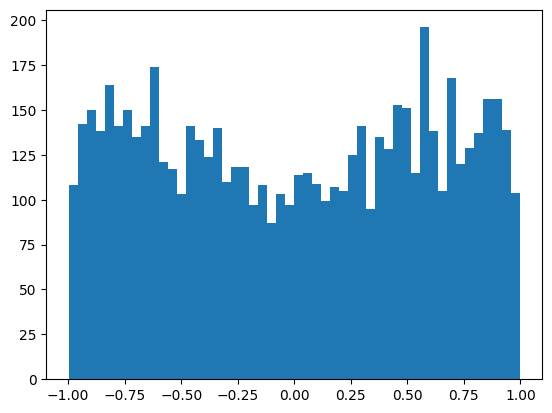

In [512]:
plt.hist(h.view(-1).tolist(), 50);

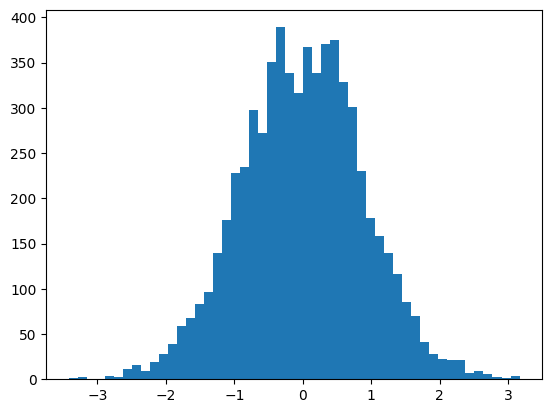

In [513]:
plt.hist(hpreact.view(-1).tolist(), 50);

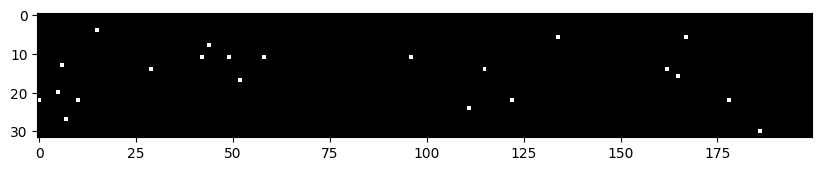

In [514]:
plt.figure(figsize=(10, 20))
plt.imshow(h.abs() >= 0.99, cmap="gray", interpolation="nearest")

### White = 1, True; and Black = 0 False;

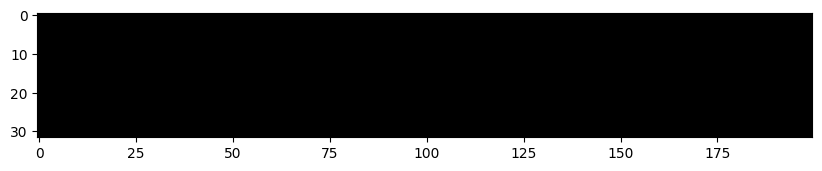

In [515]:
plt.figure(figsize=(10, 20))
plt.imshow(0 * h.abs() >= 0.99, cmap="gray", interpolation="nearest")

In [516]:
h.shape, hpreact.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

In [517]:
lossi[:10]

[2.4006481170654297,
 2.0948646068573,
 2.595405340194702,
 2.511444330215454,
 2.3574178218841553,
 2.483445644378662,
 2.4836649894714355,
 2.4073524475097656,
 2.149617910385132,
 2.2963943481445312]

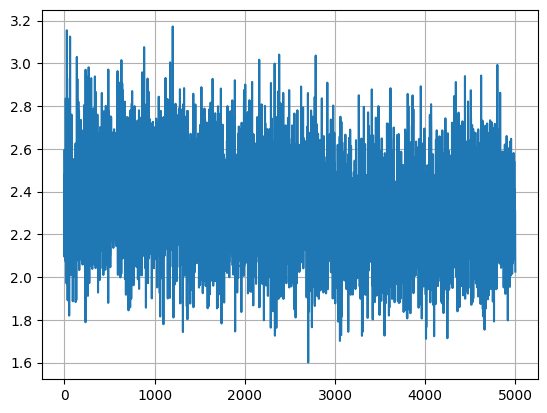

In [518]:
plt.plot(lossi)
plt.grid(True)

In [519]:
logits[0]

tensor([-2.3750,  1.3828,  0.1065, -0.0463,  0.4308,  0.7378, -0.9272, -1.1476,
        -0.3639, -0.4305,  0.0930,  1.0307,  0.7192,  0.7509,  0.2047, -0.8465,
        -0.6494, -2.5269,  0.1244,  0.8824,  0.1485, -1.6996, -1.1221, -1.2613,
        -2.3822, -0.5597, -0.4369], grad_fn=<SelectBackward0>)

In [520]:
probs = torch.softmax(logits[0], dim=0)
probs.sum()
# plt.imshow()

tensor(1., grad_fn=<SumBackward0>)

In [521]:
probs = torch.softmax(logits, dim=1)

In [522]:
probs.shape

torch.Size([32, 27])

In [523]:
probs[0].shape, probs[0].sum(), probs[1].shape, probs[1].sum()

(torch.Size([27]),
 tensor(1., grad_fn=<SumBackward0>),
 torch.Size([27]),
 tensor(1.0000, grad_fn=<SumBackward0>))

In [524]:
with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [525]:
bnmean

tensor([[-8.5588e-01, -3.1819e-01, -1.1515e+00,  5.4808e-01,  8.9008e-01,
          5.3835e-01,  1.6599e+00, -8.3008e-01, -3.8553e-01,  6.3006e-01,
         -9.7298e-01, -1.3854e+00, -4.7046e-02, -3.4668e-02, -1.3464e-03,
          4.5756e-01,  4.0053e-01, -1.6817e+00, -6.3156e-01,  7.7095e-01,
          4.0143e-01, -7.9694e-01, -1.8117e-01,  8.2255e-01,  3.9119e-01,
          7.8483e-02,  7.8003e-01,  1.7702e-01, -3.0180e-01,  8.3577e-01,
         -1.4762e-01, -8.2360e-01,  3.9367e-01,  4.3398e-01, -6.8535e-01,
         -5.6894e-01, -6.7478e-01, -1.0293e+00, -4.3422e-01,  5.0702e-01,
         -1.4858e-01, -1.0628e+00, -7.7590e-01, -1.5759e-01,  3.6557e-01,
          4.9887e-01, -2.0239e-02, -5.7479e-01,  8.8682e-01,  1.3525e+00,
          3.3554e-01,  4.2722e-01,  1.5169e+00,  1.5196e+00,  1.0103e+00,
         -1.3376e+00,  6.2047e-02,  6.2542e-01,  1.2514e+00, -7.6225e-01,
         -1.7536e-01, -6.6204e-02,  9.1363e-01,  3.6952e-01,  8.3872e-01,
          6.1196e-01,  1.0695e+00,  4.

In [526]:
bnmean_running

tensor([[-0.8054, -0.3229, -1.1752,  0.5683,  0.8605,  0.6168,  1.5217, -0.5712,
         -0.5924,  0.5369, -0.7971, -1.2548, -0.0721, -0.0548,  0.0433,  0.3647,
          0.3636, -1.4131, -0.4950,  0.8964,  0.4003, -0.7552, -0.0864,  0.7323,
          0.3558,  0.3519,  0.6412,  0.1759, -0.2393,  0.8789, -0.1993, -0.8119,
          0.3454,  0.3788, -0.7024, -0.5392, -0.7097, -0.9168, -0.2208,  0.5208,
         -0.1750, -1.0358, -0.7393, -0.2269,  0.4389,  0.3570, -0.0319, -0.5274,
          0.7456,  1.3401,  0.2632,  0.3046,  1.5083,  1.3532,  0.9859, -1.0515,
         -0.0370,  0.7227,  1.3417, -0.5797, -0.2146,  0.0224,  0.7288,  0.3407,
          0.8629,  0.5223,  0.9711,  0.4083, -0.2797,  0.0365, -0.4813,  0.8339,
          0.9554, -1.1928, -1.1312,  0.2731,  0.9970, -0.2824,  0.2872, -0.2817,
          0.7316,  0.9043,  0.9528,  0.5364,  0.1765, -0.4977, -1.0848, -0.0029,
          0.7624, -0.4722,  0.5834,  0.5653, -0.3918, -0.1552, -0.0130, -0.3686,
         -0.9179, -0.7030,  

In [527]:
bnstd

tensor([[1.8951, 1.2912, 1.5698, 1.5952, 1.8794, 1.7256, 1.2734, 1.4304, 1.9100,
         1.4509, 1.5932, 1.5437, 1.5980, 1.8637, 1.1732, 1.5836, 2.3705, 1.3646,
         1.7984, 1.7064, 1.6032, 1.8867, 1.7879, 2.0415, 1.5868, 1.5245, 1.5027,
         1.6897, 2.3165, 1.9718, 1.3025, 1.3805, 2.4087, 1.5566, 2.2974, 1.5109,
         1.4836, 2.0983, 1.7666, 1.7460, 1.5511, 1.7980, 1.7375, 2.3975, 1.4330,
         2.1122, 1.7674, 2.0222, 1.1664, 1.8317, 1.4959, 1.4941, 1.3153, 1.8292,
         1.8834, 1.7277, 1.3738, 2.0566, 2.3448, 1.4245, 1.4815, 1.5862, 1.3011,
         1.6128, 1.9022, 1.6862, 1.7664, 1.4480, 1.7126, 1.9480, 1.7846, 1.8877,
         1.5623, 1.1026, 1.4923, 1.8507, 1.9006, 2.0786, 1.9206, 1.8143, 2.3440,
         1.5415, 1.6731, 2.0897, 1.8501, 1.6885, 1.5530, 1.6809, 1.8331, 1.5306,
         1.5096, 1.7225, 1.8034, 2.8225, 2.3879, 1.6078, 2.1692, 2.0273, 1.2619,
         1.9624, 1.5557, 1.7754, 2.2456, 1.2266, 1.5895, 1.3904, 1.6405, 1.5733,
         1.7420, 1.9822, 1.8

In [528]:
bnstd_running

tensor([[1.8782, 1.2848, 1.5648, 1.5876, 1.8660, 1.7093, 1.2634, 1.4155, 1.9129,
         1.4459, 1.5784, 1.5239, 1.5806, 1.8395, 1.1694, 1.5674, 2.3491, 1.3513,
         1.7858, 1.6817, 1.5874, 1.8582, 1.7725, 2.0291, 1.5727, 1.5055, 1.4858,
         1.6820, 2.3073, 1.9624, 1.2911, 1.3692, 2.4043, 1.5395, 2.2882, 1.4970,
         1.4693, 2.1041, 1.7649, 1.7410, 1.5344, 1.7827, 1.7159, 2.3836, 1.4216,
         2.0997, 1.7435, 2.0094, 1.1489, 1.8150, 1.4778, 1.4766, 1.3151, 1.8312,
         1.8700, 1.7122, 1.3644, 2.0534, 2.3325, 1.4220, 1.4635, 1.5818, 1.2919,
         1.5932, 1.8766, 1.6653, 1.7453, 1.4367, 1.6917, 1.9375, 1.7610, 1.8765,
         1.5592, 1.0794, 1.4856, 1.8437, 1.8905, 2.0758, 1.9166, 1.7878, 2.3329,
         1.5232, 1.6741, 2.0777, 1.8279, 1.6757, 1.5550, 1.6543, 1.8262, 1.5100,
         1.5046, 1.7060, 1.7938, 2.8145, 2.3947, 1.5986, 2.1449, 2.0039, 1.2508,
         1.9439, 1.5443, 1.7516, 2.2435, 1.2087, 1.5702, 1.3704, 1.6235, 1.5524,
         1.7256, 1.9693, 1.7

In [482]:
@torch.no_grad()
def evaluate(split: str):

    data_map = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }
   
    x, y = data_map[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    print(f"{split = }, {loss.item() = }")

In [423]:
evaluate("train")    
evaluate("val")    
evaluate("test")    

split = 'train', loss.item() = 2.368637800216675
split = 'val', loss.item() = 2.3764233589172363
split = 'test', loss.item() = 2.3675591945648193


In [424]:
# sample from the model 
rg = torch.Generator().manual_seed(RANDOM_SEED + 10)

for t in range(20):
    out = []
    context = [0] * NUM_BLOCKS
    while True:
        # emb = C[torch.tensor([context])]
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs_test = F.softmax(logits)
        probs = F.softmax(logits, dim=1)
    
        ix = torch.multinomial(probs, num_samples=1, generator=rg)
        ch = itos[ix.item()]
        # print(ch)  
        context = context[1:] + [ix]
        out.append(ix)
    
        if ix == 0:
            break
    print(t, "".join(itos[i.item()] for i in out))
    
    # print("".join()

0 kqkyrrinvemusuflgzgrdyizg.
1 brcjikkygricthvumqeiznnv.
2 vphaltc.
3 jushhmith.
4 kvovavpnoxvfnckovddvnoksqlezghstrnyvovwvlucewmaalxigdloryssavamshbronttol.
5 chbrblxm.
6 strixcinrnnxxnndlydh.
7 rognnxqhrfbcklajlixxjjxxcgrdulso.
8 ngulslrickfxsphepharonembryxzhvdtt.
9 zyzckymqlijacslum.
10 jlonnn.
11 dabcamtellegujix.
12 flsthrarwuukezgb.
13 krkigkyxz.
14 nbvr.
15 dovk.
16 qhwzmwyxsmigbhslymonblamajvaigfjjuxgddynn.
17 lzxxflmqhzcerzxfiler.
18 kmbbbrixqjuwnstgrixshoreyxnnuxjangusufgqynqq.
19 jaxgrnyvaharisharbbtsonmaxrondishxrfxkks.


/tmp/ipykernel_29624/1897569945.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs_test = F.softmax(logits)


In [94]:
emb = C[torch.tensor(context)]

In [64]:
emb.shape

torch.Size([3, 10])

In [66]:
emb.view(1, -1).shape

torch.Size([1, 30])

In [63]:
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [71]:
probs_t.shape

torch.Size([1, 27])

In [72]:
probs.shape

torch.Size([1, 27])

In [74]:
probs_t.sum()

tensor(1., grad_fn=<SumBackward0>)

In [75]:
logits.shape

torch.Size([1, 27])

In [125]:
logits = torch.tensor([100.0, 0.0, 0.0, 0.0])
logits = torch.rand(4) * 100
probs = torch.softmax(logits, dim=0)

In [126]:
probs

tensor([9.9908e-01, 3.2862e-13, 9.2450e-04, 2.8196e-08])

In [127]:
loss = - probs[2].log()

In [128]:
logits, probs, loss

(tensor([61.7796, 33.0366, 54.7942, 44.3964]),
 tensor([9.9908e-01, 3.2862e-13, 9.2450e-04, 2.8196e-08]),
 tensor(6.9863))

In [313]:
torch.randn(10).shape

torch.Size([10])

In [325]:
for i in range(10):
    r = torch.randn(100)
    print(# r.mean().item(), 
          r.std().item())

0.9087595343589783
0.9427216053009033
1.2110837697982788
1.1623538732528687
1.019275188446045
1.0205391645431519
1.1242066621780396
1.078918695449829
0.9643968343734741
0.9453296065330505


### day 17

In [314]:
class Linear:
        
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if (bias is not None) else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=10**(-5), momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training: 
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_std

        xhat = (x - xman) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        with torch.no_grad():
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
    
        return self.out

    def parameters(self):
        return [selfinit.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [315]:
vocab_size, n_embed, num_blocks

(27, 10, 3)

In [419]:
C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(num_blocks * n_embed, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

In [420]:
layers[-1].weight *= 0.1
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 0.75 # 5/3 # 1 # 3

In [421]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [422]:
sum(p.nelement() for p in parameters)

172697

### optimization

In [423]:
max_steps = 500
batch_size = 32
lossi = []


for i in range(max_steps):

    # mini-batch construct
    ix = torch.randperm(X_train.shape[0], generator=rand_gen)[:batch_size]
    # print(i, ix)
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # forward pass    
    emb = C[X_batch] # embed chars into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # forward pass
    x = emb_cat
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Y_batch) # loss function


    # backward pass: 
    for layer in layers:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update rule:
    lr = 0.1 if (i < max_steps // 2) else 0.01
    for p in parameters:
        p.data += - lr * p.grad
        
    
    # stats
    if (i + 1) % (max_steps // 25) == 0:
        print(f"{i + 1:7d} / {max_steps:7d}; {loss.item():.4f}")
    
    lossi.append(loss.item())
    break


In [424]:
loss

tensor(3.8322, grad_fn=<NllLossBackward0>)

In [425]:
x.shape

torch.Size([32, 27])

In [426]:
print(f"{len(layers) = }")
[type(layer) for layer in layers]

len(layers) = 11


[__main__.Linear,
 __main__.Tanh,
 __main__.Linear,
 __main__.Tanh,
 __main__.Linear,
 __main__.Tanh,
 __main__.Linear,
 __main__.Tanh,
 __main__.Linear,
 __main__.Tanh,
 __main__.Linear]

### Visualize Tanh Outs

layer 1; name: Tanh; mean -0.0165; std: 0.6762; saturated: 20.89%
layer 3; name: Tanh; mean 0.0337; std: 0.6415; saturated: 16.70%
layer 5; name: Tanh; mean -0.0299; std: 0.6452; saturated: 18.56%
layer 7; name: Tanh; mean -0.0787; std: 0.6807; saturated: 21.64%
layer 9; name: Tanh; mean 0.0284; std: 0.6480; saturated: 20.80%


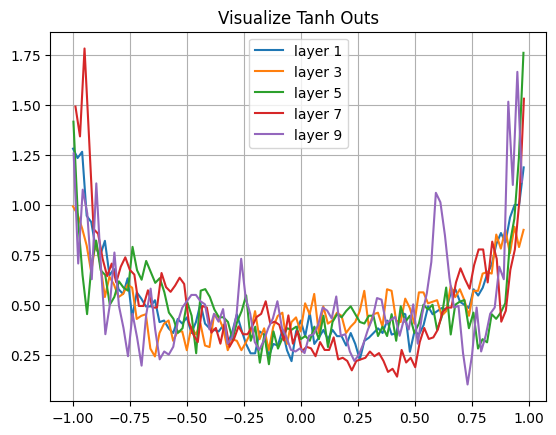

In [433]:
plt.close()
plt.grid(True)
for cnt, layer in enumerate(layers):
    # print(cnt, layer.out.shape, isinstance(layer, Tanh))
    if isinstance(layer, Tanh):
        t = layer.out
        saturated = (t.abs() > 0.90).float().mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; mean {t.mean():0.4f}; std: {t.std():0.4f}; saturated: {100 * saturated:0.2f}%")
        hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        plt.title("Visualize Tanh Outs")
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break
plt.legend()


### Visualize Tanh Grads

layer 1; name: Tanh; mean 0.0000; std: 0.0000; saturated: 0.00%
layer 3; name: Tanh; mean 0.0000; std: 0.0000; saturated: 0.00%
layer 5; name: Tanh; mean 0.0000; std: 0.0001; saturated: 0.00%
layer 7; name: Tanh; mean -0.0000; std: 0.0001; saturated: 0.00%
layer 9; name: Tanh; mean 0.0000; std: 0.0002; saturated: 0.00%


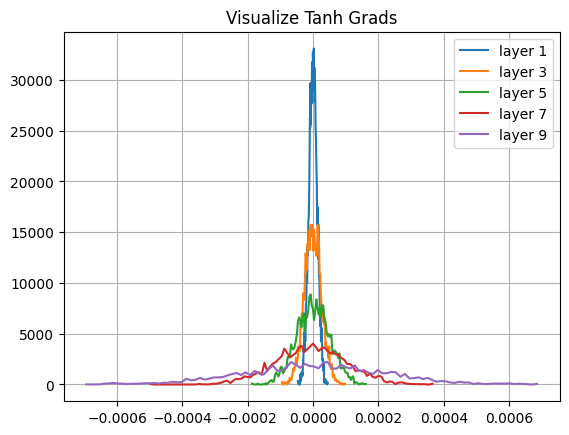

In [434]:
plt.close()
plt.grid(True)
for cnt, layer in enumerate(layers):
    # print(cnt, layer.out.shape, isinstance(layer, Tanh))
    if isinstance(layer, Tanh):
        t = layer.out.grad
        saturated = (t.abs() > 0.90).float().mean()
        name = layer.__class__.__name__
        print(f"layer {cnt}; name: {name}; mean {t.mean():0.4f}; std: {t.std():0.4f}; saturated: {100 * saturated:0.2f}%")
        hy, hx = torch.histogram(t, density=True)
        # plt.hist(t.detach())
        plt.title("Visualize Tanh Grads")
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {cnt}")
        # break
plt.legend()


In [428]:
t.detach()

tensor([[-1.5009e-04,  2.6608e-04,  7.0640e-06,  ..., -1.6659e-04,
         -2.4537e-04,  3.3392e-04],
        [ 1.9490e-04, -4.2642e-04, -5.4991e-05,  ...,  8.1762e-05,
          5.8907e-07,  1.8927e-04],
        [-3.0382e-04, -2.5108e-05, -5.3604e-05,  ...,  4.8083e-05,
          2.8183e-04, -1.6617e-04],
        ...,
        [ 3.8996e-04,  1.8311e-04,  4.4858e-04,  ...,  2.4972e-04,
          1.4046e-04, -9.1551e-05],
        [-4.0394e-04, -2.7110e-04,  6.3965e-04,  ...,  3.2309e-04,
          4.6405e-05, -1.1328e-04],
        [ 2.5214e-05, -4.7045e-05,  6.4699e-04,  ...,  2.2246e-04,
         -2.6113e-04,  1.2554e-04]])

In [429]:
(t.abs() > 0.9)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [300]:
(t.abs() > 0.9).float().mean()

tensor(0.3914)

In [308]:
layer.__class__?

Init signature: layer.__class__(fan_in: int, fan_out: int, bias: bool = True)
Docstring:      <no docstring>
Type:           type
Subclasses:     

In [310]:
layer.__class__.__dict__

mappingproxy({'__module__': '__main__',
              '__init__': <function __main__.Linear.__init__(self, fan_in: int, fan_out: int, bias: bool = True)>,
              '__call__': <function __main__.Linear.__call__(self, x)>,
              'parameters': <function __main__.Linear.parameters(self)>,
              '__dict__': <attribute '__dict__' of 'Linear' objects>,
              '__weakref__': <attribute '__weakref__' of 'Linear' objects>,
              '__doc__': None})

In [311]:
layer.__class__.__name__

'Linear'